# Custom assessment data

This notebook offers you a template to import your Bonsai custom assessment data into Jupyter. When you run a custom assessment, the assessment data will be automatically logged to your Log Analytics Workspace (LAW). Simply add your Log Analytics Workspace ID, your email alias, and the brain name, brain version, and assessment name for the assessment data that you're interested in. Then, run the notebook. The final output will be two different data frames with your custom assessment data, each of which have different formats as described at the bottom of this notebook.

To learn more about Bonsai custom assessments, use [these documents](https://docs.microsoft.com/en-us/bonsai/guides/assess-brain).

## Getting Started

### Prerequisites

If your azure subscription has not yet been registered to allow Log Analytics workspace resource provider, it needs to be registered manually using the azure-cli:

1. Type the below cli command to determine if registration is required. SUBCRIPTION_ID can be found on preview.bons.ai by clicking on id/Workspace info.

    ``` 
    az provider show --namespace "Microsoft.OperationalInsights" -o table --subscription <SUBCRIPTION_ID>
    ```

2.  If the registrationState is `Registered`, you can skip this step. If not registered, we will need to register it. This is a one-time step per subscription and the user will need owner-level permission. If you don't have the appropriate permission, work with your IT admin to execute that step.

    ```
    az login
    az provider register --namespace "Microsoft.OperationalInsights" --subscription <SUBCRIPTION_ID>
    ```

Note: A Log Analytics workspace will get created on Azure if it does not already exist in the provisioned Bonsai workspace.

### Load Kqlmagic Extension

The following cell loads the `Kqlmagic` extension into your notebook and sets the maximum number of rows to display in the output to five (the result will not be truncated however, other than by KQL's [query limit](https://docs.microsoft.com/en-us/azure/data-explorer/kusto/concepts/querylimits)). Whenever you want to use `KQL` in a cell, prepend that cell with the statement `%%kql` and only use KQL in that cell.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


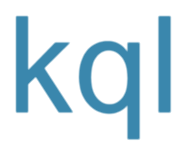

In [1]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

### Login to the log analytics workspace

Retrieve your Log Analytics workspace id using the instructions below and set the `LOG_ANALYTICS_WORKSPACE_ID` variable to that string. Then, set the alias variable to your microsoft account alias.

Instructions for accessing your Log Analystics workspace id:
1. Sign into the [Azure Portal](www.portal.azure.com).
2. Open the [list of Bonsai workspaces](https://aka.ms/portal-bonsai-workspaces) associated with your account.
3. Click on the workspace you want to query logs for.
4. Click on the log analytics workspace link in the 'Essentials' category
5. Copy your Workspace ID from the essentials sections

Please **note**, the log analytics workspace-id is the `workspace-id` of the log analytics workspace, **not** your Bonsai workspace. Once the "Copy to clipboard and authenticate" message comes up, click on the button and authenticate with your credentials to grant access to your LAW data for import.


In [3]:
LOG_ANALYTICS_WORKSPACE_ID = "ea9e6054-b7da-4e19-aa64-a2dd8fb8d7a8" 
ALIAS = 'flpydde' # add your alias. Can be anything, but should not be empty
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

<IPython.core.display.Javascript object>

## Import custom assessment data

To import data for a specific custom assessment, fill in the relevant brain_name, brain_version, and assessment_name parameters below. The data will get pulled from your Log Analytics Workspace into this notebook, so that you can analyze it here.

<div class="alert alert-block alert-danger">
<b>WARNING: KQL queries are case-sensitive and the data stored in your analytics workspace is saved as lowercase strings. Brain name and assessment name must be set as lowercase or the query options noted below will fail to find any data.
</div>

In [4]:
brain_name = "house-energy-opt-main".lower()
brain_version = 25
assessment_name = "target_assessment".lower()

#### Query

Here is our `KQL` query. Observe that we first filter the `EpisodeLog_CL` logs to the brain name, brain version and specific custom assessment we are interested in, and then join it with the `IterationLog_CL` logs so that we can see the iteration logs for each test episode within the custom assessment. Finally, using the `project` keyword, we select the set of columns we want to retain.

In [5]:
%%kql
let _brain_name = brain_name;
let _brain_version = brain_version;
let _assessment_name = assessment_name;
EpisodeLog_CL
  | where BrainName_s == _brain_name and BrainVersion_d == _brain_version and AssessmentName_s == _assessment_name
  | join kind=inner (
      IterationLog_CL
      | sort by Timestamp_t desc
  ) on EpisodeId_g
  | project 
      AssessmentName = AssessmentName_s,
      EpisodeId = EpisodeId_g,
      IterationIndex = IterationIndex_d,
      Timestamp = Timestamp_t,
      SimConfig = parse_json(SimConfig_s),
      SimState = parse_json(SimState_s),
      SimAction = parse_json(SimAction_s),
      Reward = Reward_d,
      CumulativeReward = CumulativeReward_d,
      GoalMetrics = parse_json(GoalMetrics_s),
      Terminal = Terminal_b,
      FinishReason = FinishReason_s,
      LessonIndex = LessonIndex_d,
      EpisodeType = EpisodeType_s
  | order by EpisodeId asc, IterationIndex asc


AssessmentName,EpisodeId,IterationIndex,Timestamp,SimConfig,SimState,SimAction,Reward,CumulativeReward,GoalMetrics,Terminal,FinishReason,LessonIndex,EpisodeType


[]

In [25]:
# convert kql query results in a dataframe
assessment_data = _kql_raw_result_.to_dataframe()

#### Reformatting data - converting nested arrays into new columns

Notice that the array-data as stored in `SimState`, `SimAction` and `SimConfig` are dictionaries. The following function flattens these dictionaries and creates a column for each sim config, state and action variable. Note that you may have a lot of columns after this step, so you may want to filter the data frame to the specific variables you are interested in.

In [26]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp", "IterationIndex", "Reward", "CumulativeReward", "Terminal", "SimState", "SimAction", "SimConfig", "EpisodeId"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["EpisodeId", "IterationIndex", "Reward", "Terminal"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeId", "IterationIndex"])


In [27]:
assessment_df_flattened = format_kql_logs(assessment_data)

# Resulting data for your use

There are two dataframes for your use, which contain the assessment data in different formats:
1. assessment_data - This contains iteration level data for every episode in the assessment. In this table, the SimConfig, SimState and SimAction columns contain dictionaries, which include the values for all configs, states and actions respectively in one dictionary.

2. assessment_df_flattened - This also contains iteration level data for every episode in the assessment. However in this dataframe, there is a separate colummn to represent each sim config, state and action variable associated with your brain. This dataframe will have a lot of columns.

Note: each assessment episode will have a unique episode id.

In [28]:
assessment_data.head(5)

,AssessmentName,EpisodeId,IterationIndex,Timestamp,SimConfig,SimState,SimAction,Reward,CumulativeReward,GoalMetrics,Terminal,FinishReason,LessonIndex,EpisodeType
0,custom_assessment_1,09e6c8cd-5b2c-4a37-89be-ff565c46039b,1.0,2021-04-28 17:50:10.280000+00:00,"{'initial_vel_y': 0.00887244145906466, 'initia...","{'roll': -0.1474263658608645, 'pitch': 0.01515...",None,0.000000,240.860535,"{'driveGoalMetrics': [{'success': 1, 'percenta...",False,Interrupted,0.0,Assessment
1,custom_assessment_1,09e6c8cd-5b2c-4a37-89be-ff565c46039b,2.0,2021-04-28 17:50:10.298000+00:00,"{'initial_vel_y': 0.00887244145906466, 'initia...","{'roll': 0.14447516202926636, 'pitch': -0.0486...","{'input_pitch': -0.04860736057162285, 'input_r...",0.229702,240.860535,"{'driveGoalMetrics': [{'success': 1, 'percenta...",False,Interrupted,0.0,Assessment
2,custom_assessment_1,09e6c8cd-5b2c-4a37-89be-ff565c46039b,3.0,2021-04-28 17:50:10.314000+00:00,"{'initial_vel_y': 0.00887244145906466, 'initia...","{'roll': 0.14897875487804413, 'pitch': -0.0455...","{'input_roll': 0.14897875487804413, 'input_pit...",0.213542,240.860535,"{'driveGoalMetrics': [{'success': 1, 'percenta...",False,Interrupted,0.0,Assessment
3,custom_assessment_1,09e6c8cd-5b2c-4a37-89be-ff565c46039b,4.0,2021-04-28 17:50:10.332000+00:00,"{'initial_vel_y': 0.00887244145906466, 'initia...","{'roll': 0.14817072451114657, 'pitch': -0.0423...","{'input_pitch': -0.042338937520980835, 'input_...",0.226637,240.860535,"{'driveGoalMetrics': [{'success': 1, 'percenta...",False,Interrupted,0.0,Assessment
4,custom_assessment_1,09e6c8cd-5b2c-4a37-89be-ff565c46039b,5.0,2021-04-28 17:50:10.347000+00:00,"{'initial_vel_y': 0.00887244145906466, 'initia...","{'roll': 0.14392556250095367, 'pitch': -0.0383...","{'input_roll': 0.14392556250095367, 'input_pit...",0.271455,240.860535,"{'driveGoalMetrics': [{'success': 1, 'percenta...",False,Interrupted,0.0,Assessment


In [29]:
assessment_df_flattened.head(5)

,EpisodeId,IterationIndex,Reward,Terminal,roll,pitch,height_z,time_delta,jitter,step_time,...,ball_fell_off,iteration_count,input_pitch,input_roll,initial_vel_y,initial_vel_x,initial_y,initial_x,initial_roll,initial_pitch
1004,09e6c8cd-5b2c-4a37-89be-ff565c46039b,1.0,0.000000,False,-0.147426,0.015158,0.0,0.045,0.0,0.045,...,0.0,0.0,NaN,NaN,0.008872,-0.010112,-0.010579,-0.033317,-0.147426,0.015158
1005,09e6c8cd-5b2c-4a37-89be-ff565c46039b,2.0,0.229702,False,0.144475,-0.048607,0.0,0.045,0.0,0.045,...,0.0,1.0,-0.048607,0.144475,0.008872,-0.010112,-0.010579,-0.033317,-0.147426,0.015158
1006,09e6c8cd-5b2c-4a37-89be-ff565c46039b,3.0,0.213542,False,0.148979,-0.045567,0.0,0.045,0.0,0.045,...,0.0,2.0,-0.045567,0.148979,0.008872,-0.010112,-0.010579,-0.033317,-0.147426,0.015158
1007,09e6c8cd-5b2c-4a37-89be-ff565c46039b,4.0,0.226637,False,0.148171,-0.042339,0.0,0.045,0.0,0.045,...,0.0,3.0,-0.042339,0.148171,0.008872,-0.010112,-0.010579,-0.033317,-0.147426,0.015158
1008,09e6c8cd-5b2c-4a37-89be-ff565c46039b,5.0,0.271455,False,0.143926,-0.038331,0.0,0.045,0.0,0.045,...,0.0,4.0,-0.038331,0.143926,0.008872,-0.010112,-0.010579,-0.033317,-0.147426,0.015158
